In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from arch import arch_model
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

In [189]:
# stock_path = './Dataset/Stocks/'
stock_path = './Dataset/Stocks_dow/'
img_path = './Images/'
DJ_path = './Dataset/Dow Jones/'
rf_path = './Dataset/US1M/'

In [461]:
class Strategy():
    def __init__(self, stock_path, train_start, train_end, test_start, test_end):
        self.stock_path = stock_path
        self.stock_list = os.listdir(stock_path)
        self.stock_list = [stock for stock in self.stock_list if stock.endswith('.csv')]  # filter out the csv files

        # time
        self.train_start = train_start
        self.train_end = train_end
        self.test_start = test_start
        self.test_end = test_end

        # price/volume data
        self.high = self.extract_data('High', train_start, test_end)
        self.low = self.extract_data('Low', train_start, test_end)
        self.open = self.extract_data('Open', train_start, test_end)
        self.close = self.extract_data('Close', train_start, test_end)
        self.volume = self.extract_data('Volume', train_start, test_end)
        self.adjclose = self.extract_data('Adj Close', train_start, test_end)

        # Dow Jones Index
        self.dj_index = pd.read_csv(DJ_path + 'DIA.csv')
        self.dj_index['Date'] = pd.to_datetime(self.dj_index['Date'])
        self.dj_index.set_index('Date', inplace=True)

        # risk-free rate
        self.rf = pd.read_csv(rf_path + 'DGS1MO.csv')
        self.rf['DATE'] = pd.to_datetime(self.rf['DATE'])
        self.rf.set_index('DATE', inplace=True)
        self.rf = self.rf.replace('.', np.nan).reindex(self.adjclose.index, method='ffill').astype(float) / 100

        # train/test data
        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)
        self.dj_train = self.dj_index[(self.dj_index.index >= self.train_start) & (self.dj_index.index <= self.train_end)]
        self.dj_test = self.dj_index[(self.dj_index.index >= self.test_data.index[0]) & (self.dj_index.index <= self.test_end)]
        self.rf_train = self.rf[(self.rf.index >= self.train_start) & (self.rf.index <= self.train_end)]
        self.rf_test = self.rf[(self.rf.index >= self.test_data.index[0]) & (self.rf.index <= self.test_end)]
        
        # models
        self.scaler = None; self.pca = None; self.garch_model = None
        # daily return
        self.train_return = None; self.test_return = None
        # standardized return
        self.scaled_train = None; self.scaled_test = None
        # principal components
        self.pc_train = None; self.pc_test = None
        # market index
        self.train_index = None; self.test_index = None
        # weights
        self.weights_pc = None  # weights of each PC
        self.weights_stock = None  # weights of stocks in the index
        self.weight_stockpool = None  # investment weights in the stock pool in the prediction period

        self.forecast = None


    # =========================================================================
    # Data Tool
    # =========================================================================
    def extract_data(self, variable, start_date, end_date):
        '''
        extract specific data from our dataset
        '''
        for stock in self.stock_list:
            data = pd.read_csv(stock_path + stock)
            data['Date'] = pd.to_datetime(data['Date'])
            data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
            data = data[['Date', variable]]
            data = data.rename(columns={variable: stock[:-4]})
            if stock == self.stock_list[0]:
                df = data
            else:
                df = pd.merge(df, data, on='Date', how='left')
        df.set_index('Date', inplace=True)
        return df
    
    def drop_stock(self):
        '''
        drop stock which has missing values
        '''
        self.adjclose = self.adjclose.dropna(axis=1)
        self.stock_list = self.adjclose.columns.tolist()
        self.high = self.high[self.stock_list]
        self.low = self.low[self.stock_list]
        self.open = self.open[self.stock_list]
        self.close = self.close[self.stock_list]
        self.volume = self.volume[self.stock_list]

        self.train_data = self.adjclose[(self.adjclose.index >= self.train_start) & (self.adjclose.index <= self.train_end)]
        self.test_data = self.adjclose[(self.adjclose.index >= self.test_start) & (self.adjclose.index <= self.test_end)]
        self.test_data = pd.concat([self.train_data.iloc[-1:], self.test_data], axis=0)

    
    # =========================================================================
    # Market Index
    # =========================================================================
    def pca_analysis(self, n_components=10, save=False):
        '''
        PCA analysis for the stock market index
        : return: cumulative explained variance ratio
        '''
        # calculate the return
        self.train_return = self.train_data.pct_change().dropna()
        self.test_return = self.test_data.pct_change().dropna()

        # data standardization
        self.scaler = StandardScaler()
        self.scaled_train = self.scaler.fit_transform(self.train_data)
        self.scaled_train = pd.DataFrame(self.scaled_train, index=self.train_data.index, columns=self.train_data.columns)

        # PCA analysis
        pca = PCA(n_components=n_components)
        pca.fit(self.scaled_train)

        # explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_

        if save:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='o', color='skyblue')
            plt.xlabel('Principal Component')
            plt.ylabel('Explained Variance Ratio')
            plt.title('Explained Variance Ratio of Principal Components')
            plt.grid(linestyle='--', alpha=0.3)
            plt.savefig(img_path + 'explained_variance_ratio.png')

        return explained_variance_ratio.cumsum()
    
    def stock_weights(self, n_components=3, plot=True):
        '''
        compute the weights of each stock in the market index
        '''
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.scaled_train)

        # compute weight of each PC
        self.weights_pc = self.pca.explained_variance_ratio_
        self.weights_pc = self.weights_pc / self.weights_pc.sum()

        # compute the stock weights
        loadings = self.pca.components_.T  # loadings of each stock on each PC
        loadings_df = pd.DataFrame(loadings, index=self.stock_list, columns=['PC'+str(i) for i in range(1, n_components+1)])
        # weighted average of loadings
        loadings_df['Weighted Loadings'] = np.abs(np.sum(loadings_df * self.weights_pc, axis=1))
        # normalize the weighted loadings
        self.weights_stock = loadings_df['Weighted Loadings'] / np.sum(loadings_df['Weighted Loadings'])

        if plot:
            stock_weights = self.weights_stock.sort_values(ascending=False)
            plt.figure(figsize=(8, 8))
            plt.pie(stock_weights, labels=stock_weights.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues'))
            plt.title('Stock Weights in the Market Index')

        return self.weights_stock

    def market_volatility(self):
        market_index_volatility = np.zeros((len(self.forecast.columns), 1))
        corr = self.train_return.corr()
        # go through each forecast
        for i, col in enumerate(self.forecast.columns):
            self.weighted_vol = self.weights_stock.values * self.forecast[col]
            market_index_volatility[i] = np.sqrt(np.dot(np.dot(self.weighted_vol.values.T, corr), self.weighted_vol.values))
        market_index_volatility = pd.DataFrame(market_index_volatility)
        self.forcast_mktvol = market_index_volatility
        return market_index_volatility
    
    # =========================================================================
    # Volatility Prediction
    # =========================================================================
    def volatility_prediction(self, mean='Constant'):
        '''
        predict the volatility of the market index (GARCH model)
        : return: model summary & forecast
        '''
        pred_horizon = self.test_data.shape[0] - 1  # prediction horizon

        stock_return = 100 * self.train_data.pct_change().dropna()

        params = {}
        pvalues = {}
        forcast = {}

        for stock in self.stock_list:
            garch_model = arch_model(stock_return[stock], mean=mean, vol='Garch', p=1, q=1)
            garch_model = garch_model.fit(disp='off')
            params[stock] = garch_model.params
            pvalues[stock] = garch_model.pvalues
            forecast = garch_model.forecast(horizon=pred_horizon)
            forcast[stock] = forecast.variance.iloc[-1].values

        params_df = pd.DataFrame(params).T
        pvalues_df = pd.DataFrame(pvalues).T
        self.forecast = pd.DataFrame(forcast).T

        return params_df, pvalues_df, self.forecast
    
    # =========================================================================
    # Strategy
    # =========================================================================
    def strategy_1(self, h=0.5, _lambda=1):
        '''
        fixed function: market vol -> weights
        '''
        def weight_func(x, _lambda=_lambda):
            return (1 + h) * np.exp(-_lambda * x) / (h + np.exp(-_lambda * x))
        
        self.weight_stockpool = weight_func(self.forcast_mktvol)
        self.weight_stockpool.index = self.test_data.iloc[1:].index

        return self.weight_stockpool

    def strategy_2(self):
        pass        
        

    # =========================================================================
    # Performance Evaluation
    # =========================================================================
    def perf_eval(self, plot=True, save=True):
        '''
        calculate the performance of the strategy
        '''
        # portfolio return
        dj_return = self.dj_test['Adj Close'].pct_change().dropna()
        portfolio_return = self.weight_stockpool.values.flatten() * dj_return  + \
            (1 - self.weight_stockpool.values.flatten())  * self.rf_test.iloc[1:].mean().values[0] / 252
        # self.weight_stockpool * dj_return + (1 - self.weight_stockpool) * self.rf_test.iloc[1:].mean() / 252
        portfolio_cum_return = (portfolio_return + 1).cumprod()
        portfolio_nav = pd.Series(np.insert(portfolio_cum_return, 0, 1), index=self.test_data.index) * self.dj_test['Adj Close'].iloc[0]

        if plot:
            # plot
            plt.figure(figsize=(10, 6))
            plt.plot(portfolio_nav, label='Portfolio Nav', color='skyblue')
            plt.plot(self.dj_test['Adj Close'], label='DIA', color='orange')
            plt.xlabel('Date')
            plt.ylabel('Nav')
            plt.title('Performance of the Portfolio')
            plt.legend(loc='best')
            plt.grid(linestyle='--', alpha=0.3)
            if save:
                plt.savefig(img_path + 'portfolio_performance.png')
        
        # annualized sharpe ratio for the portfolio and dj
        excess_return = (portfolio_nav.iloc[-1] / portfolio_nav.iloc[0] - 1) * 12 - self.rf_test.iloc[1:].mean()
        return_vol = portfolio_return.std() * np.sqrt(12)
        sharpe_ratio = (excess_return / return_vol).values[0]
        sharpe_ratio_dj = ((self.dj_test['Adj Close'].iloc[-1] / self.dj_test['Adj Close'].iloc[0] - 1) * 12 - self.rf_test.iloc[1:].mean()) / (dj_return.std() * np.sqrt(12))
        sharpe_ratio_dj = sharpe_ratio_dj.values[0]

        # maximum drawdown
        max_drawdown = 1 - portfolio_nav / portfolio_nav.cummax()
        max_drawdown_dj = 1 - self.dj_test['Adj Close'] / self.dj_test['Adj Close'].cummax()

        eval_sheet = pd.DataFrame({'Monthly Return': [portfolio_nav.iloc[-1] / portfolio_nav.iloc[0] - 1, self.dj_test['Adj Close'].iloc[-1] / self.dj_test['Adj Close'].iloc[0] - 1],
                                   'Sharpe Ratio': [sharpe_ratio, sharpe_ratio_dj],
                                   'Max Drawdown': [max_drawdown.max(), max_drawdown_dj.max()]},
                                  index=['Portfolio', 'DIA'])

        return portfolio_nav, self.dj_test['Adj Close'], eval_sheet     
    

    # =========================================================================
    # Visualization Tool
    # =========================================================================
    def vis_nan(self):
        '''
        visualize the missing values in the dataset
        '''
        # the nan number of each column & plot
        nan_num = self.adjclose.isnull().sum() / self.adjclose.shape[0]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=nan_num.index, y=nan_num.values, color='skyblue')
        plt.xticks(rotation=90)
        plt.xlabel('Stock')
        plt.title('Missing Value Proportion of Each Stock')
        plt.grid(linestyle='--', alpha=0.3)
        # label the non-zero value
        for i, v in enumerate(nan_num):
            if v > 0:
                plt.text(i, v, round(v, 2), ha='center', va='bottom', fontsize=8)
        plt.savefig(img_path + 'missing_value_proportion.png')

In [462]:
train_start = pd.to_datetime('2012-01-01')
train_end = train_start + pd.DateOffset(years=10) - pd.DateOffset(days=1)  # training period: 10 years
test_start = train_end + pd.DateOffset(days=1)
test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)   # testing period: 1 month

print('Train Period:', train_start, 'to', train_end)
print('Test Period:', test_start, 'to', test_end)

model = Strategy(stock_path, train_start, train_end, test_start, test_end)

Train Period: 2012-01-01 00:00:00 to 2021-12-31 00:00:00
Test Period: 2022-01-01 00:00:00 to 2022-01-31 00:00:00


stock number: 30


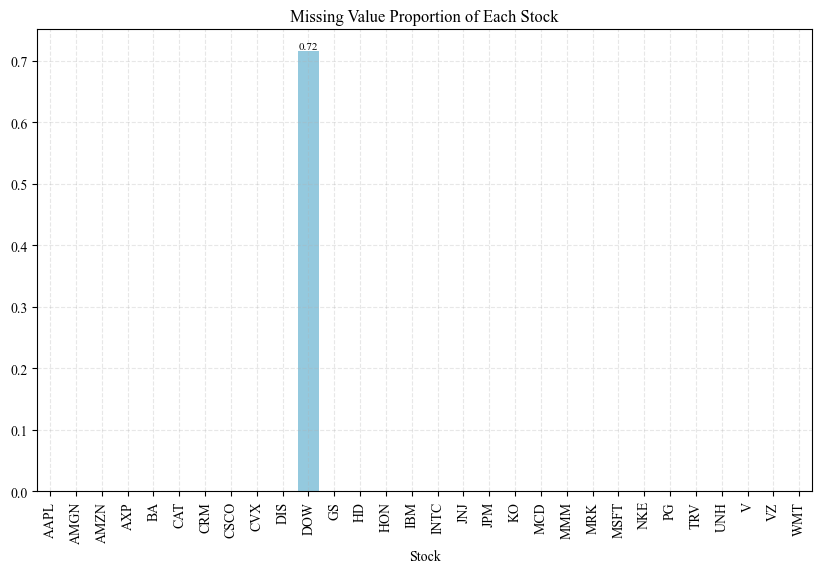

In [463]:
print('stock number:', len(model.stock_list))
model.vis_nan()   # we will not use DOW in our portfolio

In [464]:
model.drop_stock()   # according to the above figure, some stocks have too many missing values, so we drop them
print('stock number:', len(model.stock_list))

stock number: 29


In [465]:
model.pca_analysis()   # PCA analysis

array([0.84208154, 0.89391719, 0.94197713, 0.96025838, 0.96936386,
       0.97693598, 0.98152502, 0.98528824, 0.9882176 , 0.99033147])

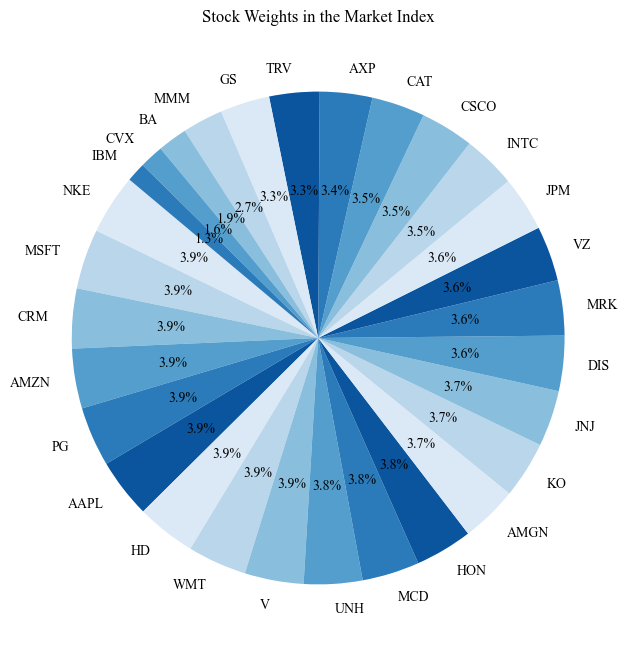

In [466]:
stock_weights = model.stock_weights(3, True)  # compute the weights of each stock in the market index

In [467]:
params_df, pvalues_df, forecast = model.volatility_prediction()  # volatility prediction
pvalues_df

,mu,omega,alpha[1],beta[1]
AAPL,1.136214e-08,0.000468,1.464377e-06,4.294720e-140
AMGN,2.169968e-03,0.014596,7.057378e-05,3.827734e-108
AMZN,4.538587e-06,0.002610,3.583366e-05,2.176955e-59
AXP,4.017507e-05,0.020034,2.879777e-07,0.000000e+00
BA,2.153295e-04,0.030924,5.617074e-05,1.438961e-203
CAT,1.623943e-02,0.095604,2.398687e-02,4.381109e-80
CRM,2.598457e-03,0.032950,4.186944e-02,5.644466e-16
CSCO,4.372149e-03,0.021807,8.561909e-03,2.269035e-32
CVX,7.252803e-02,0.001673,1.346503e-06,0.000000e+00
DIS,1.802267e-02,0.124349,6.582274e-03,1.526076e-173


In [468]:
model.market_volatility()  # market index volatility

,0
0,1.084828
1,1.122609
2,1.155771
3,1.185203
4,1.211578
5,1.235409
6,1.257090
7,1.276927
8,1.295163
9,1.311994


In [469]:
model.strategy_1(h=0.1, _lambda=0.5)

,0
Date,
2022-01-03,0.938554
2022-01-04,0.935935
2022-01-05,0.933606
2022-01-06,0.931518
2022-01-07,0.929627
2022-01-10,0.927905
2022-01-11,0.926325
2022-01-12,0.924870
2022-01-13,0.923523


In [470]:
model.weight_stockpool

,0
Date,
2022-01-03,0.938554
2022-01-04,0.935935
2022-01-05,0.933606
2022-01-06,0.931518
2022-01-07,0.929627
2022-01-10,0.927905
2022-01-11,0.926325
2022-01-12,0.924870
2022-01-13,0.923523


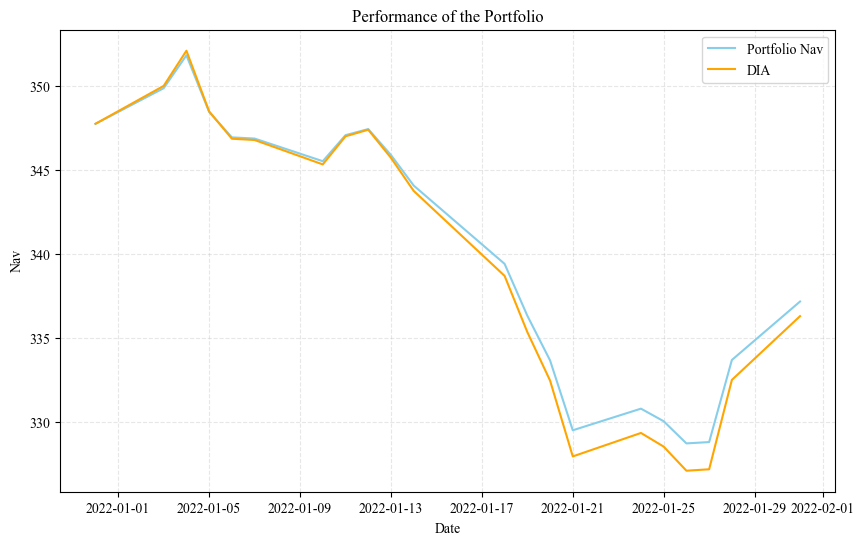

In [471]:
portfolio_nav, market_index, eval_sheet  = model.perf_eval()

In [472]:
eval_sheet

,Monthly Return,Sharpe Ratio,Max Drawdown
Portfolio,-0.030465,-14.080451,0.065750
DIA,-0.032971,-14.024659,0.071102


## Strategy: Monthly Adjustment

In [473]:
# 2012-01-01 ~ 2013-12-01 freq=1M
start_time_list = pd.date_range(start='2012-01-01', end='2013-12-01', freq='MS')

# 存放月收益率
strategy_return_list = []
market_return_list = []
strategy_sharpe_list = []
market_sharpe_list = []
strategy_maxdrawdown_list = []
market_maxdrawdown_list = []

for i in range(len(start_time_list)):
    print('Start Time:', start_time_list[i])
    train_start = start_time_list[i]
    train_end = train_start + pd.DateOffset(years=10) - pd.DateOffset(days=1)
    test_start = train_end + pd.DateOffset(days=1)
    test_end = test_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    model = Strategy(stock_path, train_start, train_end, test_start, test_end)
    model.drop_stock()
    vol_prop = model.pca_analysis()
    stock_w = model.stock_weights(3, False)
    params, pvalues, fore = model.volatility_prediction()  # volatility prediction
    pred_vol = model.market_volatility()
    index_w = model.strategy_1(h=0.1, _lambda=0.5)
    portfolio_nav, market_index, eval_sheet  = model.perf_eval(plot=False, save=False)
    strategy_return_list.append(eval_sheet.loc['Portfolio', 'Monthly Return'])
    market_return_list.append(eval_sheet.loc['DIA', 'Monthly Return'])   
    strategy_sharpe_list.append(eval_sheet.loc['Portfolio', 'Sharpe Ratio'])
    market_sharpe_list.append(eval_sheet.loc['DIA', 'Sharpe Ratio'])
    strategy_maxdrawdown_list.append(eval_sheet.loc['Portfolio', 'Max Drawdown'])
    market_maxdrawdown_list.append(eval_sheet.loc['DIA', 'Max Drawdown'])

# test_start_time_list = start_time_list + 10 years
test_start_time_list = start_time_list + pd.DateOffset(years=10)
strategy_return_list = pd.Series(strategy_return_list, index=test_start_time_list)
market_return_list = pd.Series(market_return_list, index=test_start_time_list)
strategy_sharpe_list = pd.Series(strategy_sharpe_list, index=test_start_time_list)
market_sharpe_list = pd.Series(market_sharpe_list, index=test_start_time_list)
strategy_maxdrawdown_list = pd.Series(strategy_maxdrawdown_list, index=test_start_time_list)
market_maxdrawdown_list = pd.Series(market_maxdrawdown_list, index=test_start_time_list)

Start Time: 2012-01-01 00:00:00
Start Time: 2012-02-01 00:00:00
Start Time: 2012-03-01 00:00:00
Start Time: 2012-04-01 00:00:00
Start Time: 2012-05-01 00:00:00
Start Time: 2012-06-01 00:00:00
Start Time: 2012-07-01 00:00:00
Start Time: 2012-08-01 00:00:00
Start Time: 2012-09-01 00:00:00
Start Time: 2012-10-01 00:00:00
Start Time: 2012-11-01 00:00:00
Start Time: 2012-12-01 00:00:00
Start Time: 2013-01-01 00:00:00
Start Time: 2013-02-01 00:00:00
Start Time: 2013-03-01 00:00:00
Start Time: 2013-04-01 00:00:00
Start Time: 2013-05-01 00:00:00
Start Time: 2013-06-01 00:00:00
Start Time: 2013-07-01 00:00:00
Start Time: 2013-08-01 00:00:00
Start Time: 2013-09-01 00:00:00
Start Time: 2013-10-01 00:00:00
Start Time: 2013-11-01 00:00:00
Start Time: 2013-12-01 00:00:00


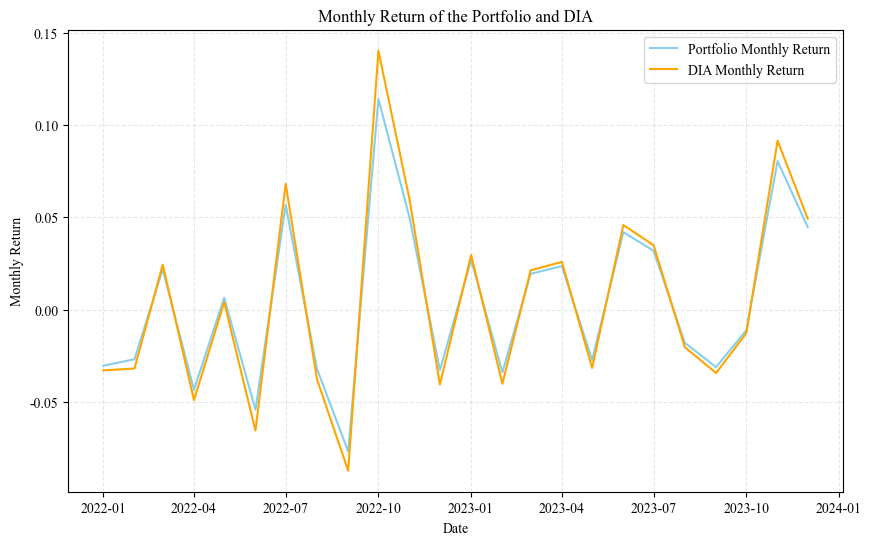

In [474]:
# plot strategy return and market return
plt.figure(figsize=(10, 6))
plt.plot(strategy_return_list, label='Portfolio Monthly Return', color='skyblue')
plt.plot(market_return_list, label='DIA Monthly Return', color='orange')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.title('Monthly Return of the Portfolio and DIA')
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.3)

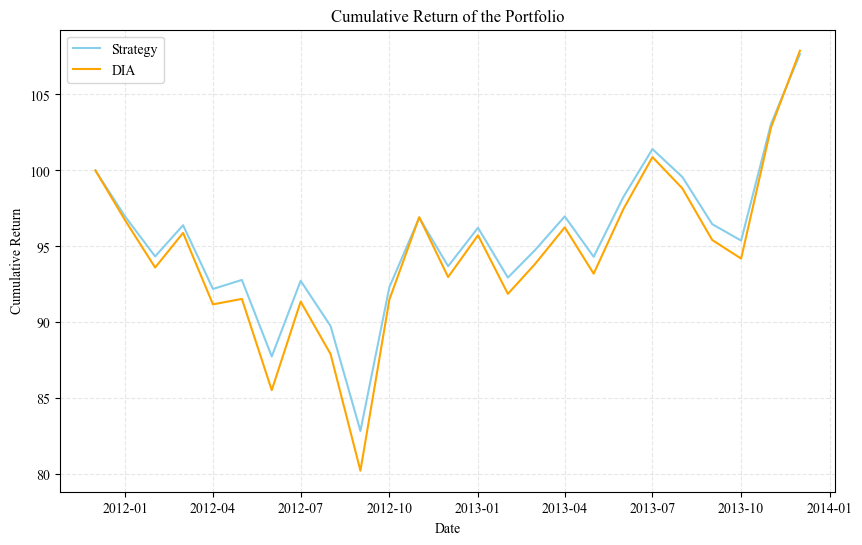

Strategy Sharpe Ratio: 0.4218856750695493
Market Sharpe Ratio: 0.38944590226692294


In [475]:
# cumulative return
strategy_cum_return = (strategy_return_list + 1).cumprod()
# add 1 mon before the start time to the index
new_index = pd.date_range(start_time_list[0] - pd.DateOffset(months=1), periods=len(strategy_cum_return) + 1, freq='MS')
strategy_nav = pd.Series(np.insert(strategy_cum_return.values, 0, 1) * 100, index=new_index)
market_cum_return = (market_return_list + 1).cumprod()
market_nav = pd.Series(np.insert(market_cum_return.values, 0, 1) * 100, index=new_index)

# plot
plt.figure(figsize=(10, 6))
plt.plot(strategy_nav, label='Strategy', color='skyblue')
plt.plot(market_nav, label='DIA', color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of the Portfolio')
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.3)
plt.show()

# calc sharpe ratio
strategy_excess_return = (strategy_cum_return.iloc[-1] - 1) / 2 - model.rf.mean() * 2
strategy_return_vol = strategy_return_list.std() * np.sqrt(0.5)
strategy_sharpe = (strategy_excess_return / strategy_return_vol).values[0]
# DIA sharpe ratio
market_excess_return = (market_cum_return.iloc[-1] - 1) / 2 - model.rf.mean() * 2
market_return_vol = market_return_list.std() * np.sqrt(0.5)
market_sharpe = (market_excess_return / market_return_vol).values[0]
print('Strategy Sharpe Ratio:', strategy_sharpe)
print('Market Sharpe Ratio:', market_sharpe)

<Axes: xlabel='Date'>

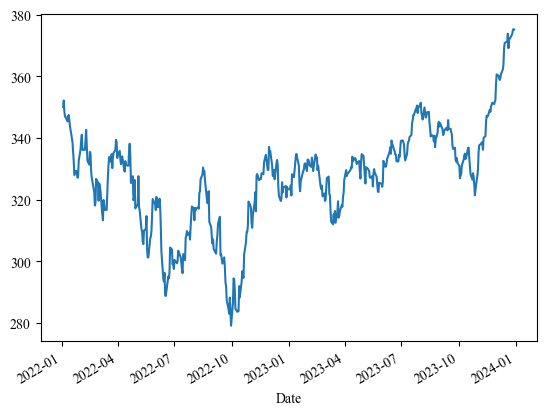

In [477]:
model.dj_index['Adj Close'].loc['2022-01-01':'2023-12-31'].plot()